# MedMCQA Classification using Gemini

In [ ]:
import pandas as pd
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import random
from collections import Counter
from tqdm.auto import tqdm
import google.generativeai as genai

# Disable W&B logging if set
import os
os.environ["WANDB_DISABLED"] = "true"

# Your Gemini API key here

GOOGLE_API_KEY = 'your-api-key-here'

genai.configure(api_key=GOOGLE_API_KEY)
gemini = genai.GenerativeModel("gemini-1.5-flash")  # or "gemini-1.5-pro"


In [ ]:
# Load MedMCQA Parquet splits (replace with local or HF URL)
splits = {
    "train": "data/train-00000-of-00001.parquet",
    "test": "data/test-00000-of-00001.parquet",
}
train_df = pd.read_parquet(f"hf://datasets/openlifescienceai/medmcqa/{splits['train']}")
test_df  = pd.read_parquet(f"hf://datasets/openlifescienceai/medmcqa/{splits['test']}")

# Downsample for quick iteration
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df  = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Filter to top-k subject classes
top_k = 21
top_subjects = train_df["subject_name"].value_counts().nlargest(top_k).index
train_df = train_df[train_df["subject_name"].isin(top_subjects)]
test_df  = test_df [test_df["subject_name"].isin(top_subjects)]

# Final inputs
X_train = train_df["question"]
y_train = train_df["subject_name"]
X_test  = test_df["question"]
y_test  = test_df["subject_name"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_df.head()

,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
0,f138d54e-2681-4e90-9b13-f5f18f1ce5c8,Normal visual acuity of 6/6 is achieved by the...,2 years,3 years,5 years,7 years,1,single,Ans. 3 years Full visual acuity (6/6) is attai...,Ophthalmology,None
1,ff8d6367-cb09-4b32-8e90-82aaa0fb481d,Primary feature of small intestinal obstruction -,Fever,High peristalsis with colic,Abdominal distension,Empty rectum,1,multi,None,Surgery,None
2,713c17e0-4499-4743-8aea-7066b1412eee,Regarding unicornuate uterus true is,Defect in fusion of mullerian ducts,Single uterus with 2 fallopian tubes,One duct is completely absent,Best reproductive outcome,2,multi,Unicornuate uterus is not defect in fusion of ...,Gynaecology & Obstetrics,None
3,bead378e-5abd-4b58-a926-28f13a9a6a89,Characteristic lab findings of hemophilia A ar...,a,c,ac,bc,3,single,Hemophilia A ...,Pediatrics,None
4,961a48c9-787e-488f-af6e-13b41f1c47d5,What is true about HER2/neu overexpression in ...,Good prognosis,Responds well to taxanes,Responds well to monoclonal antibodies,Seen only in breast cancer,2,multi,".* Tumour grade, growth factor and oncogene fa...",Surgery,Endocrinology and breast


In [ ]:
# merge_map = {
#     "Medicine": "Medicine & Pathology",
#     "Pathology": "Medicine & Pathology",
#     "Orthopaedics": "Surgery & Orthopaedics",
#     "Surgery": "Surgery & Orthopaedics",
#     "Skin": "Skin & Dental",
#     "Dental": "Skin & Dental"
# }


def format_mcq(row):
    return f"""Q: {row['question']}
A. {row['opa']}
B. {row['opb']}
C. {row['opc']}
D. {row['opd']}"""

# Build a small support set for few-shot prompt construction
N_SHOTS_PER_LABEL = 5
support_examples = []

for label in le.classes_:
    rows = train_df[train_df["subject_name"] == label]\
        .sort_values("question", key=lambda s: s.str.len())\
        .head(N_SHOTS_PER_LABEL)

    for _, row in rows.iterrows():
        support_examples.append({
            "mcq": format_mcq(row),
            "label": label,
            "exp": row["exp"]  # ← added explanation
        })

random.shuffle(support_examples)


In [ ]:
# Gemini prompt builder (flat format)
def build_prompt(question_row) -> str:


    shots = "\n\n".join(
        f"{ex['mcq']}\nSubject: {ex['label']}"
        for ex in support_examples
    )

    current_q = format_mcq(question_row)
    return f"""You are a medical expert. Your task is to classify the subject of each multiple-choice question.

Choose only from this list: {', '.join(le.classes_)}.

Respond with only the subject name. Do not say anything else. Do not give a list.



Now classify:
{current_q}
Subject:"""

In [ ]:
# Gemini classification call


def classify_with_gemini(row) -> str:
    response = gemini.generate_content(
        build_prompt(row),
        generation_config={
            "temperature": 0.0,
            "top_p": 0.0,
            "max_output_tokens": 10
        }
    )
    return response.text.strip()


Evaluation Section

In [ ]:
# Evaluate on a sample

sample_rows = test_df.head(20)
preds = [classify_with_gemini(row) for _, row in tqdm(sample_rows.iterrows(), total=len(sample_rows))]
acc = (sample_rows["subject_name"].values == preds).mean()
print(f"Gemini Flash MCQ prompt accuracy: {acc:.2%}")



  0%|          | 0/20 [00:00<?, ?it/s]

Gemini Flash MCQ prompt accuracy: 60.00%


In [ ]:
correct = 0
for row, pred in zip(sample_rows.itertuples(), preds):
    gold = row.subject_name
    print(f"Q: {row.question[:120]}...\nGold: {gold}\nPred: {pred}\n")
    if pred == gold:
        correct += 1

print(f"\nManual recheck accuracy: {correct / len(preds):.2%}")


Q: A child is suffering from recurrent chronic infections with encapsulated bacteria is due to deficiency of subclass ....
Gold: Microbiology
Pred: Pediatrics

Q: N-butyl cyanoacrylate is used for:...
Gold: Surgery
Pred: Surgery

Q: A 45 year old female presents with mass in Right Breast, Upper Outer guardant. Mammography shows a specific type of calc...
Gold: Unknown
Pred: Radiology

Q: Amino acid used in Carnitine synthesis is?...
Gold: Unknown
Pred: Biochemistry

Q: Abnormal thick labial frenum results in:...
Gold: Dental
Pred: Dental

Q: Tumor with maximum bone matrix...
Gold: Surgery
Pred: Orthopaedics

Q: True about breathing are all except ?...
Gold: Physiology
Pred: Physiology

Q: Complement mediated hypersensitivity reaction is?...
Gold: Pathology
Pred: Pathology

Q: First line investigation for deep venous thrombosis is -...
Gold: Radiology
Pred: Radiology

Q: PDL has the inherent capacity to withstand how much amount of force:...
Gold: Dental
Pred: Dental

Q: Low osmolar ORS

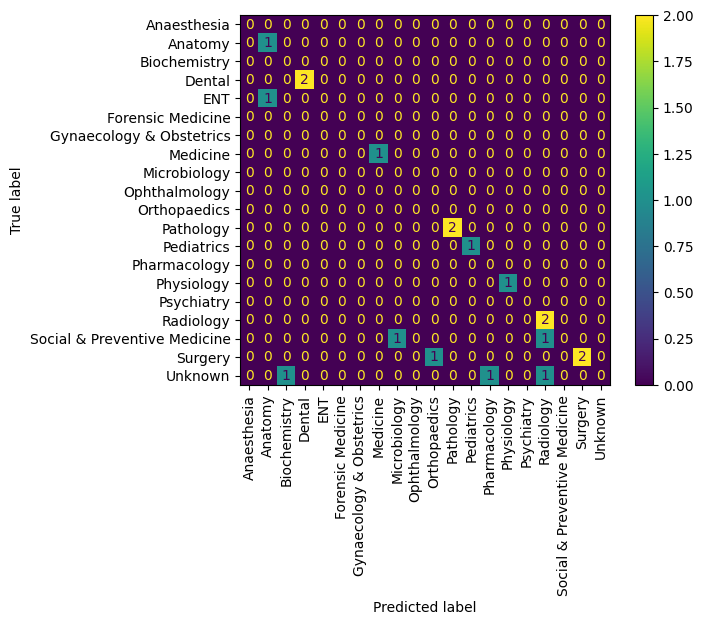

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = sample_rows["subject_name"].values
y_pred = preds

cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90)


In [ ]:
filtered = sample_rows[sample_rows["subject_name"] != "Unknown"].copy()


In [ ]:
# Evaluate on a sample

# sample_rows = test_df.head(20)
preds = [classify_with_gemini(row) for _, row in tqdm(filtered.iterrows(), total=len(filtered))]
acc = (filtered["subject_name"].values == preds).mean()
print(f"Gemini Flash MCQ prompt accuracy: {acc:.2%}")

Test on 100 Samples

In [ ]:
hundred = test_df[test_df["subject_name"] != "Unknown"].sample(3000, random_state=42)

preds = [classify_with_gemini(row) for _, row in tqdm(hundred.iterrows(), total=len(hundred))]
acc = (hundred["subject_name"].values == preds).mean()
print(f"Gemini Flash MCQ prompt accuracy: {acc:.2%}")


  0%|          | 0/3000 [00:00<?, ?it/s]

Gemini Flash MCQ prompt accuracy: 68.07%


In [ ]:

# Ensure all labels are strings (not sets, lists, etc.)
filtered_y_true = [str(label).strip() for label in filtered_y_true]
filtered_y_pred = [str(label).strip() for label in filtered_y_pred]

# List of allowed labels (all lowercase, consistently sorted)
allowed_subjects = sorted([
    "anaesthesia", "anatomy", "biochemistry", "dental", "ent", "forensic medicine",
    "gynaecology", "medicine", "microbiology", "ophthalmology", "orthopaedics",
    "pathology", "pediatrics", "pharmacology", "physiology", "psychiatry",
    "radiology", "skin", "social and preventive medicine", "surgery"
])

# Compute and plot confusion matrix
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=allowed_subjects)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=allowed_subjects)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix for Gemini Flash MCQ Classification (Filtered & Cleaned)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True and predicted labels
y_true = hundred["subject_name"].values
y_pred = preds

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true) | set(y_pred)))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_true) | set(y_pred)))
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix for Gemini Flash MCQ Classification")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get the known labels from the encoder
known_labels = set(le.classes_)

# Step 2: Filter out invalid predictions
valid_rows = [pred in known_labels for pred in preds]

# Step 3: Apply the filter to both y_true and preds
filtered_y_true = hundred["subject_name"].values[valid_rows]
filtered_preds = [pred for pred in preds if pred in known_labels]

# Step 4: Encode the filtered labels
y_true_encoded = le.transform(filtered_y_true)
y_pred_encoded = le.transform(filtered_preds)

# Step 5: Get unique label indices present in the filtered data
present_label_indices = sorted(set(np.concatenate([y_true_encoded, y_pred_encoded])))

# Step 6: Generate the report with matching target_names
print(classification_report(
    y_true_encoded,
    y_pred_encoded,
    labels=present_label_indices,
    target_names=le.classes_[present_label_indices],
    digits=2,
    zero_division=0
))


                              precision    recall  f1-score   support

                 Anaesthesia       0.76      0.81      0.79        32
                     Anatomy       0.61      0.88      0.72       119
                Biochemistry       0.63      0.96      0.76       185
                      Dental       0.94      0.69      0.79       650
                         ENT       0.72      0.83      0.77        46
           Forensic Medicine       0.80      0.71      0.76        63
    Gynaecology & Obstetrics       0.90      0.90      0.90       296
                    Medicine       0.56      0.59      0.57       199
                Microbiology       0.52      0.74      0.61        89
               Ophthalmology       0.93      0.96      0.94        94
                Orthopaedics       0.00      0.00      0.00         0
                   Pathology       0.61      0.44      0.51       158
                  Pediatrics       0.60      0.72      0.65        99
                Pha

In [ ]:
# Check unique labels in true and predicted data
true_labels = set(y_true)
pred_labels = set(y_pred)

print("Unique labels in y_true:", sorted(true_labels))
print("Unique labels in y_pred:", sorted(pred_labels))

# Check if any labels are predicted that were never in true labels
unexpected_preds = pred_labels - true_labels
missing_preds = true_labels - pred_labels

print("Labels in predictions but not in true labels:", unexpected_preds)
print("Labels in true labels but never predicted:", missing_preds)


Unique labels in y_true: ['Anaesthesia', 'Anatomy', 'Biochemistry', 'Dental', 'ENT', 'Forensic Medicine', 'Gynaecology & Obstetrics', 'Medicine', 'Microbiology', 'Ophthalmology', 'Pathology', 'Pediatrics', 'Pharmacology', 'Physiology', 'Psychiatry', 'Radiology', 'Social & Preventive Medicine', 'Surgery']
Unique labels in y_pred: ['Anaesthesia', 'Anatomy', 'Biochemistry', 'Biostatistics', 'Cardiology', 'Cell Biology', 'Cytogenetics', 'Dental', 'Dermatology', 'ENT', 'Endocrinology', 'Entomology', 'Forensic Medicine', 'Genetics', 'Gynaecology & Obstetrics', 'Haematology', 'Histology', 'Immunology', 'Materials Science', 'Medicine', 'Microbiology', 'Neurology', 'Nuclear Medicine', 'Obstetrics & Gynaecology', 'Oncology', 'Ophthalmology', 'Orthopaedics', 'Parasitology', 'Pathology', 'Pediatrics', 'Pharmacology', 'Physiology', 'Psychiatry', 'Radiology', 'Social & Preventive Medicine', 'Statistics', 'Surgery', 'Unknown']
Labels in predictions but not in true labels: {'Nuclear Medicine', 'Cell B